In [33]:
import os
import imageio
from PIL import Image
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from DataLoading import DataLoad
from EncoderArch import Encoder
from DecoderArch import Decoder
from Loss import get_loss
from TrainerConstruct import Trainer
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [77]:
# CHANGE THE ENCODER PATH
ENCODER_PATH = 'vae_encoder_20250411_160125.pth'

# CHANGE THE PATH IF DATA CHANGE
DATASET_PATH = "./Data/images_original"

# KEEP THE LATENT SPACE SIZE THE SAME UNLESS MODEL ARCH CHENGES
LATENT_SPACE_SIZE = 128 

# CHOOSE THE GENRE YOU ARE INTERESTED IN
class1 = "blues"
class2 = "classical"

classes = ['blues', 'classical', 'country', 'disco', 
 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [79]:
def load_model(encoder_path):
    encoder = Encoder(LATENT_SPACE_SIZE)
    encoder.load_state_dict(torch.load('vae_encoder_20250411_160125.pth'))
    encoder.eval()
    return encoder

In [81]:
def prepare_data(DATASET_PATH):
    dx, dy = 0, 0
    dimx, dimy = 128, 128
    batch_size = 64
    
    dataload = DataLoad(DATASET_PATH)
    all_photos, all_attrs = dataload.fetch_dataset(dx, dy, dimx, dimy)
    all_photos = np.array(all_photos / 255, dtype='float32')
    
    return all_photos, all_attrs

In [83]:
def encode_images(encoder, images):
    with torch.no_grad():
        images_tensor = torch.from_numpy(images)
        images_tensor = images_tensor.permute(0, 3, 1, 2)
        mu, logvar, z = encoder(images_tensor)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z.numpy()

In [85]:
def latent_space_2d(encoder, data1, label1, data2, label2):
    """Visualize latent space using PCA"""
    data1_encoding = encode_images(encoder, data1)
    data2_encoding = encode_images(encoder, data2)
    
    data1_flat = data1_encoding.reshape(data1_encoding.shape[0], -1)
    data2_flat = data2_encoding.reshape(data2_encoding.shape[0], -1)
    
    combined_data = np.vstack((data1_flat, data2_flat))

    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(combined_data)

    transformed_data1 = transformed_data[:len(data1)]
    transformed_data2 = transformed_data[len(data1):]

    plt.figure(figsize=(8, 4))
    plt.scatter(transformed_data1[:, 0], transformed_data1[:, 1], color='blue', label=label1)
    plt.scatter(transformed_data2[:, 0], transformed_data2[:, 1], color='orange', label=label2)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"2D PCA of {label1} vs. {label2}")
    plt.legend()
    plt.grid(False)
    plt.show()

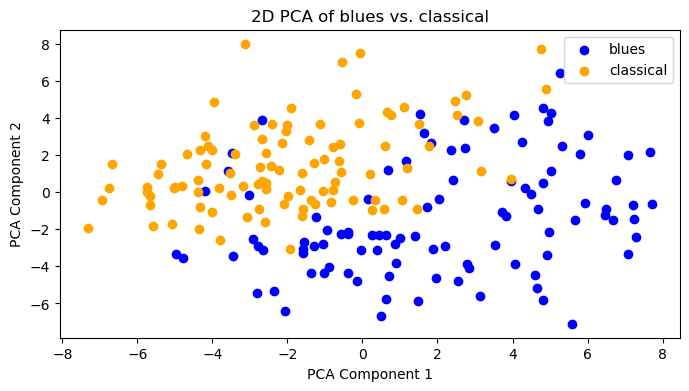

In [89]:
if __name__ == "__main__":
    all_photos, all_attrs = prepare_data(DATASET_PATH)
    encoder = load_model(ENCODER_PATH)
    class1_index = classes.index(class1)
    class2_index = classes.index(class2)
    class1_idx = np.where(all_attrs == class1_index)
    class2_idx = np.where(all_attrs == class2_index)
    
    data1 = all_photos[class1_idx]
    data2 = all_photos[class2_idx]
    
    # Visualize latent space
    latent_space_2d(encoder, data1, class1, data2, class2)